# Ripe and Rotte Mangoes

El conjunto de datos Ripe y Rotten contiene datos sobre dos estados del mango. Este es un conjunto de datos multi-variables para determinar el estado de un mango a traves de una imagen.

El conjunto de datos contiene dos estados en los que se puede encontrar un mango que son: Ripe (Maduro) y Rotten (Podrido). Cada estado cuenta con una cantidad de ejemplos registrados. Rotten: 1492 imágenes y Ripe: 497 imágenes para un total de 1.989 ejemplos en el conjunto de das.to

Debido a problemas de vectorización al intentar sacar la máscara binaria de las imagenes, se trabajara sólo con 294 máscasra de la clase Ripe y 541 de la clase Rotten, para un total de 835 ejemplos en el conjunto de doss.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
import warnings
import os
import skimage as ski
import statistics
from skimage.data import page
from skimage.measure import regionprops
from scipy.stats import skew, kurtosis

Función para cargar el conjunto de datos y las rutas en dónde se escuentan las máscaras.

In [4]:
path_ripe = "ripe_masks"
path_rotten = "rotten_masks"

data_mask = []

def load_images_from_folder(folder_path, label):
    for filename in os.listdir(folder_path):
        if filename.endswith(".npy"):
            mask_path = os.path.join(folder_path, filename)
            mask = np.load(mask_path)
            data_mask.append({'mask': mask, 'label': label, 'mask_path':mask_path})


# load_images_from_folder(path_ripe, 'Ripe')
# load_images_from_folder(path_rotten, 'Rotten')

# print(f"{len(data_mask)} Máscaras cargadas.")

Creando un dataframe con las máscaras para visualizar la distribución de las clases Ripe y Rotten en el conjunto de datos

In [8]:
# df_mask = pd.DataFrame(data_mask)
# print(df_mask.head())

# if not df_mask.empty:
#     plt.figure(figsize = (10,8))
#     sns.countplot(x = 'label', data = df_mask)
#     plt.title("Conteo de imagenes: Ripe vs Rotten")
#     plt.xlabel("Estados")
#     plt.ylabel("Cantidad de imagenes o máscaras")
#     plt.xticks(rotation = 45)
#     plt.show()
# else:
#     print("No hay imagenes para mostrar en el histograma.")
    

Como podemos ver a continuación, esta es la máscara binaria de uno de los ejemplos cargados en el dataframe. Basicamente, esta es la imagen que representa una mascara binaria.

In [11]:
# mask_file = df_mask['mask_path'].iloc[0]
# mask = np.load(mask_file)
# fig, ax = plt.subplots(figsize=(8, 6))
# ax.imshow(mask, cmap='gray')
# ax.set_title('Máscara binaria')
# ax.axis('off')
# plt.show()

Aquí podemos ver el contenido o cada una de las columnas del dataframe. La mascara binaria cargada, el tipo(label) y el path de la máscara.

In [14]:
# df_mask.info()

NameError: name 'df_mask' is not defined

A continuación vamos a buscar extraer las propiedades más importantes de la máscara que pueden guardar relación con el estado del mango a través de la libreria regionprops. Esta función, recibe como argumento la máscara binaria del mango en forma de array y retorna un diccionario con las propiedades que fueron extraídas. Se realizan los respectivos cálculos derivados, se definen las coordenadas para los calculos estadisticos. Dentro de estas propiedades se encuentran: Propiedades básicas como el área, el perimetro, excentricidad y la solidez, propiedades derivadas, como el área convexa, estadisticas de forma, momentos de Hu y estadisticas de distribución espacial. 

In [16]:
def extract_mask_properties(mask):
    if mask.ndim > 2:
        mask = np.max(mask, axis=0)
    props = regionprops(mask.astype(int))[0]
    
    # Cálculos derivados
    form_factor = 4 * np.pi * props.area / (props.perimeter ** 2) if props.perimeter > 0 else 0
    aspect_ratio = props.major_axis_length / props.minor_axis_length if props.minor_axis_length > 0 else 0
    
    # Coordenadas para cálculos estadísticos
    coords = np.column_stack(np.where(mask))
    
    properties = {
        # Propiedades básicas
        'area': props.area,
        'perimeter': props.perimeter,
        'eccentricity': props.eccentricity,
        'solidity': props.solidity,
        'major_axis_length': props.major_axis_length,
        'minor_axis_length': props.minor_axis_length,
        'orientation': props.orientation,
        'extent': props.extent,
        
        # Propiedades derivadas
        'form_factor': form_factor,
        'aspect_ratio': aspect_ratio,
        'convex_area': props.convex_area,
        'filled_area': props.filled_area,
        'euler_number': props.euler_number,
        
        # Estadísticas de forma
        'equivalent_diameter': props.equivalent_diameter,
        'bbox_area': props.bbox_area,
        
        # Momentos de Hu (invariantes a rotación, escala y traslación)
        'hu_moment_1': props.moments_hu[0],
        'hu_moment_2': props.moments_hu[1],
        'hu_moment_3': props.moments_hu[2],
        'hu_moment_4': props.moments_hu[3],
        
        # Estadísticas de distribución espacial
        'skewness_x': skew(coords[:, 0]) if len(coords) > 0 else 0,
        'skewness_y': skew(coords[:, 1]) if len(coords) > 0 else 0,
        'kurtosis_x': kurtosis(coords[:, 0]) if len(coords) > 0 else 0,
        'kurtosis_y': kurtosis(coords[:, 1]) if len(coords) > 0 else 0
    }
    
    return properties

Luego, tenemos la siguiente función que se encargara de recorrer el dataframe que contiene todas las mascaras y aplicar la función anterior. Analizando el conjunto de datos completo.

In [19]:
def analyze_masks_dataset():
    
    load_images_from_folder(path_ripe, 'Ripe')
    load_images_from_folder(path_rotten, 'Rotten')
    
    print(f"{len(data_mask)} Máscaras cargadas.")
    
    # Crear DataFrame base
    df_mask = pd.DataFrame(data_mask)
    
    # Extraer propiedades de cada máscara
    properties_list = []
    for mask in df_mask['mask']:
        properties = extract_mask_properties(mask)
        properties_list.append(properties)
    
    # Crear DataFrame de propiedades
    df_properties = pd.DataFrame(properties_list)
    
    # Combinar con las etiquetas
    df_properties['label'] = df_mask['label']
    
    return df_properties

Como se puede observar, esta función realiza lo mismo que hicimos en el primer momento de este notebook; que fue cargar las máscaras binarias. 
Ahora, lo que haremos, será crear una serie de funciones que se encargarán de la visualización de las propiedades extraídas, a través de gráficos.

1. Visualización de la distribución de las clases

In [23]:
def plot_class_distribution(df):
    plt.figure(figsize=(10, 6))
    sns.countplot(x='label', data=df)
    plt.title("Distribución de Clases: Ripe vs Rotten")
    plt.xlabel("Estado del Mango")
    plt.ylabel("Cantidad")
    plt.show()

2. Botplox para propiedades númericas extraídas

In [26]:
def plot_boxplots(df):
    # Obtener columnas numéricas
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    # Configurar grid
    n_properties = len(numeric_cols)
    n_cols = 3
    n_rows = (n_properties + n_cols - 1) // n_cols
    
    # Crear figura
    plt.figure(figsize=(20, 5 * n_rows))
    
    for i, prop in enumerate(numeric_cols, 1):
        plt.subplot(n_rows, n_cols, i)
        sns.boxplot(x='label', y=prop, data=df)
        plt.xticks(rotation=45)
        plt.title(prop)
        
        # Formato para números grandes
        if df[prop].max() > 1000:
            plt.gca().yaxis.set_major_formatter(
                plt.FuncFormatter(lambda x, p: format(int(x), ','))
            )
        
        # Rotar etiquetas largas
        if len(prop) > 15:
            plt.xticks(rotation=45)
            
    plt.tight_layout()

3. Visualización de la matriz de correlación entre las propiedades

In [29]:
def plot_correlation_matrix(df):
    # Obtener columnas numéricas
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    correlation = df[numeric_cols].corr()
    
    # Crear máscara para el triángulo superior
    mask = np.triu(np.ones_like(correlation, dtype=bool))
    
    # Crear figura
    plt.figure(figsize=(15, 12))
    sns.heatmap(correlation, 
                mask=mask,
                annot=True, 
                cmap='coolwarm', 
                center=0,
                fmt='.2f',
                square=True,
                linewidths=.5,
                cbar_kws={"shrink": .5})
    
    plt.title("Matriz de Correlación de Propiedades")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

4. Creación de histogramas para las propiedades más relevantes.

In [32]:
def plot_histograms(df):
    main_properties = [
        'area', 'perimeter', 'eccentricity', 'solidity', 'form_factor',
        'aspect_ratio', 'equivalent_diameter', 'convex_area'
    ]
    
    for prop in main_properties:
        if prop in df.columns:
            plt.figure(figsize=(10, 6))
            for label in df['label'].unique():
                sns.histplot(data=df[df['label'] == label], 
                           x=prop, 
                           label=label, 
                           alpha=0.5,
                           stat='density',
                           kde=True)
            plt.title(f"Distribución de {prop} por Clase")
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()

5. Creación de violin plots para las propiedades más discriminativas.

In [35]:
def plot_violin_plots(df):
    most_discriminative = ['area', 'perimeter', 'form_factor', 'equivalent_diameter']
    
    plt.figure(figsize=(15, 6))
    for i, prop in enumerate(most_discriminative, 1):
        if prop in df.columns:
            plt.subplot(1, 4, i)
            sns.violinplot(x='label', y=prop, data=df)
            plt.title(prop)
            plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

6. Para la visualización de las relaciones entre pares de propiedades relevantes, toma como argumento las propiedades y etiquetas del dataframe.

In [38]:
def plot_property_relationships(df):
    main_properties = ['area', 'perimeter', 'form_factor']
    
    # Crear scatter plots para pares de propiedades
    plt.figure(figsize=(15, 5))
    for i, (prop1, prop2) in enumerate(zip(main_properties, main_properties[1:]), 1):
        plt.subplot(1, 3, i)
        sns.scatterplot(data=df, x=prop1, y=prop2, hue='label', alpha=0.6)
        plt.title(f"{prop1} vs {prop2}")
    
    plt.tight_layout()
    plt.show()

7. Luego, tenemos la siguiente función que se encarga de ejecutar cada una de las anteriores, como vemos, también recibe el dataframe.

In [41]:
def visualize_properties(df):
    print("1. Distribución de clases")
    plot_class_distribution(df)
    
    print("\n2. Blox plots")
    plot_boxplots(df)
    
    print("\n3. Matriz de correlación")
    plot_correlation_matrix(df)
    
    print("\n4. Histogramas")
    plot_histograms(df)
    
    print("\n5. Violin plots")
    plot_violin_plots(df)
    
    print("\n6. Relaciones entre propiedades")
    plot_property_relationships(df)

8. Y como última función para esta parte, tenemos la siguiente que realiza un análisis de las caracteristicas principales o más relevantes.

In [44]:
def generate_analysis(df):
    print("Análisis de Propiedades:")
    plot_class_distribution(df)
    plot_boxplots(df)
    plot_correlation_matrix(df)

Finalmente, llamaremos a cada una de estas funciones para obtener y visualizar los datos o variables de estudio.

835 Máscaras cargadas.
1. Distribución de clases


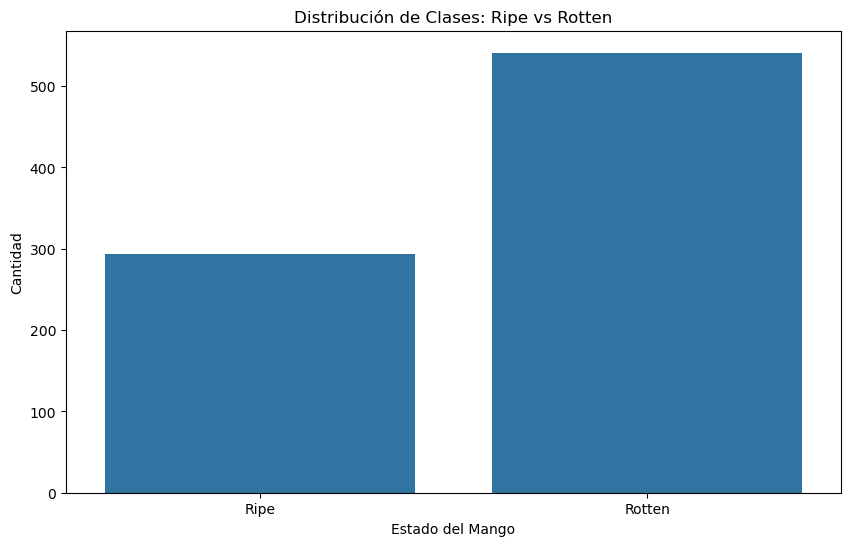


2. Blox plots

3. Matriz de correlación


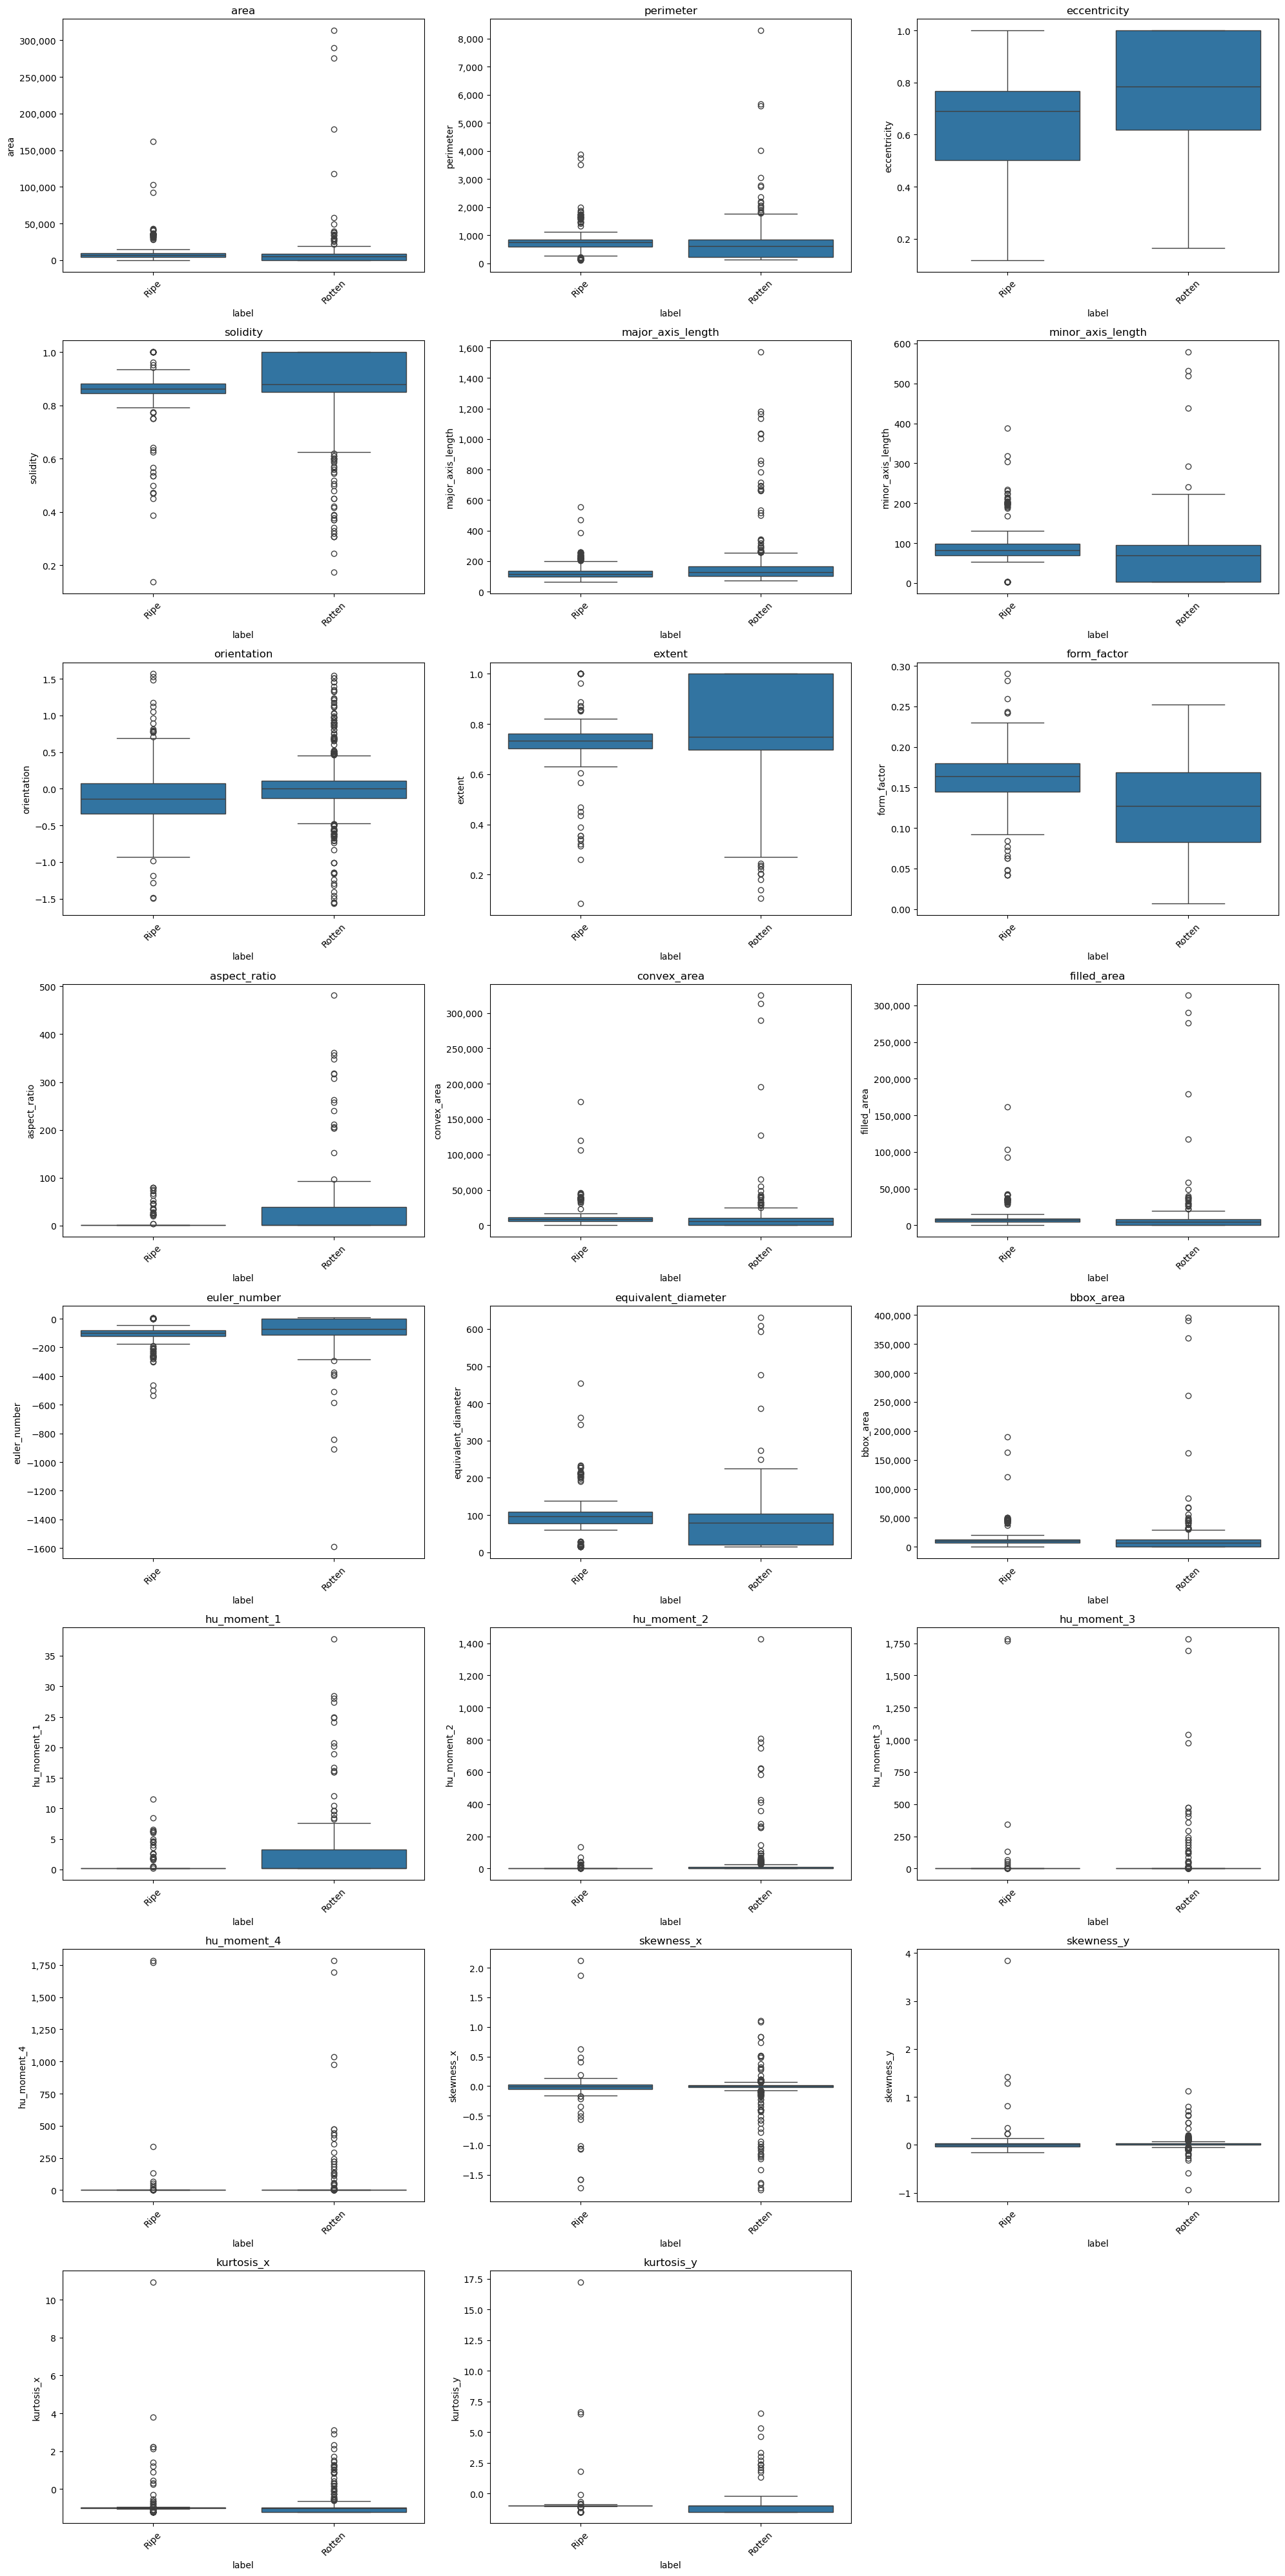

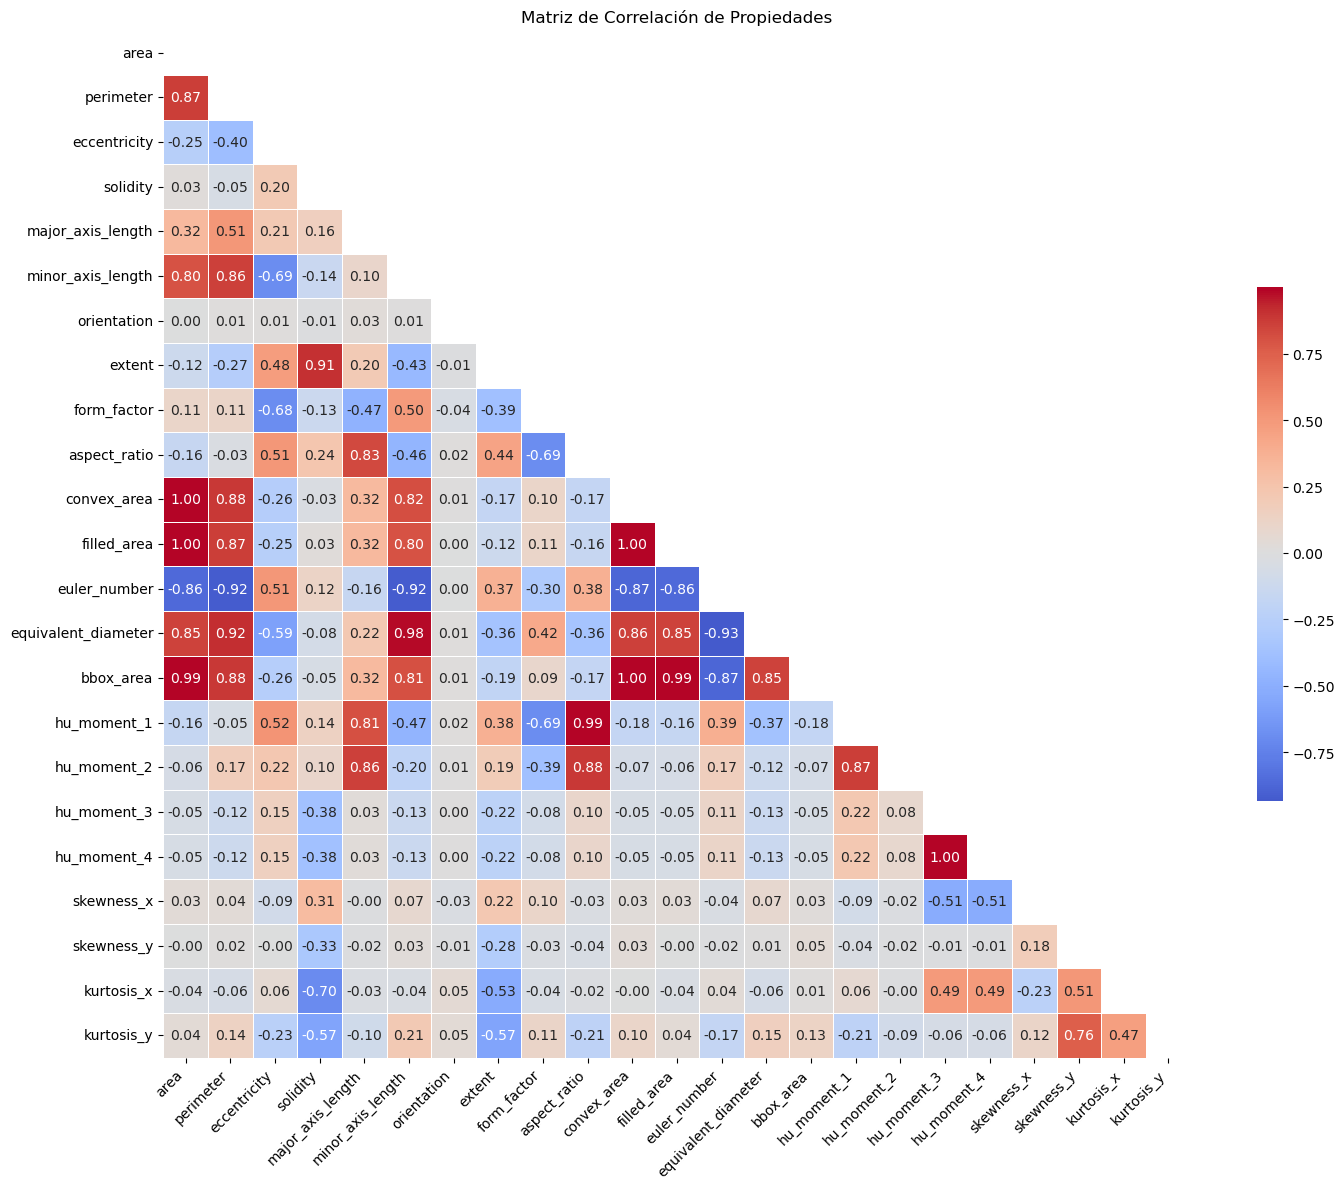


4. Histogramas


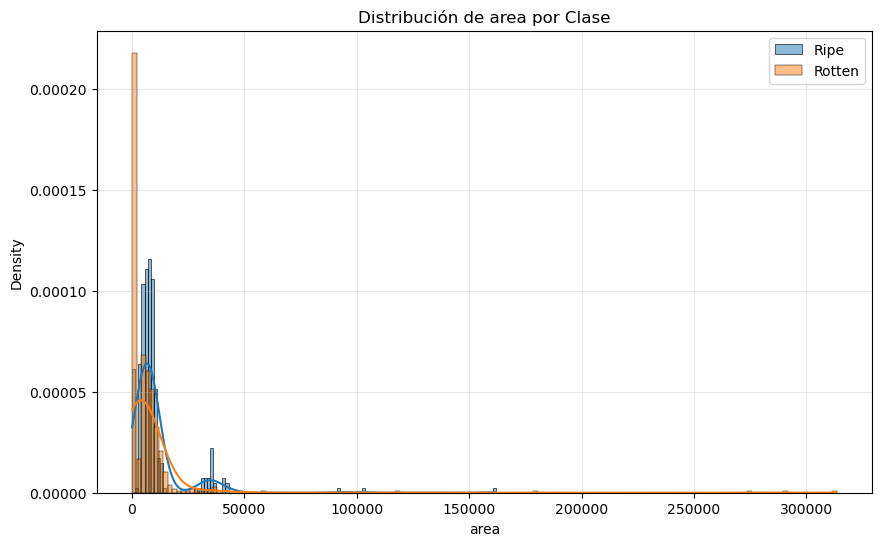

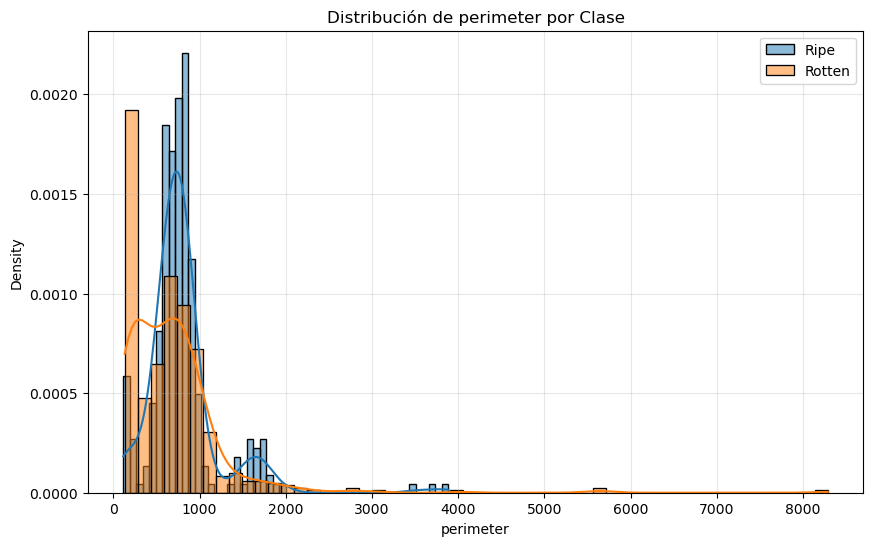

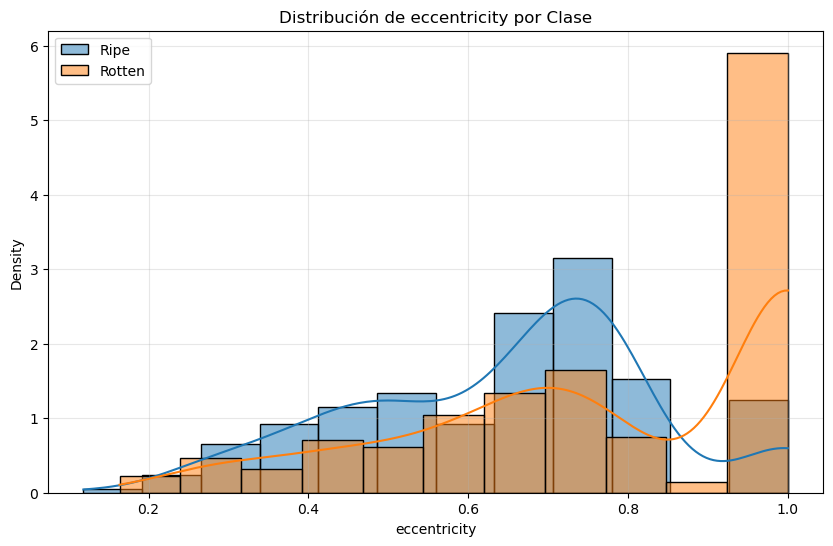

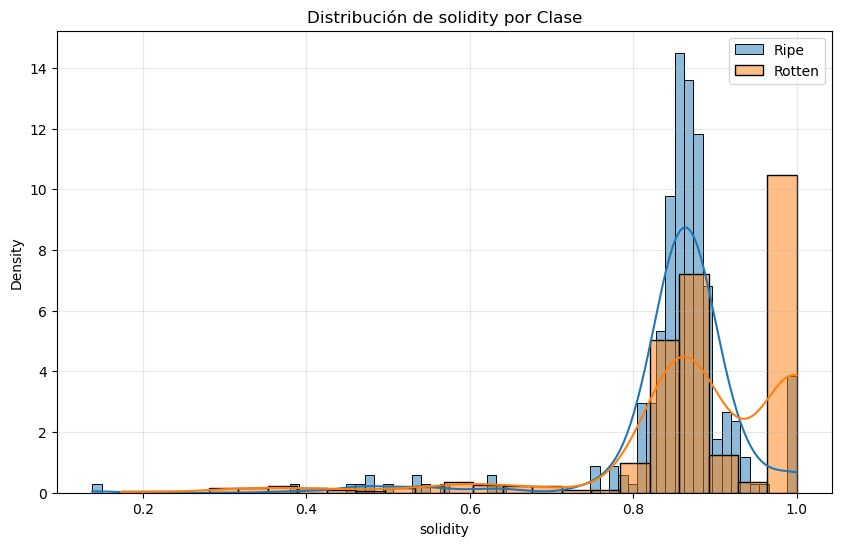

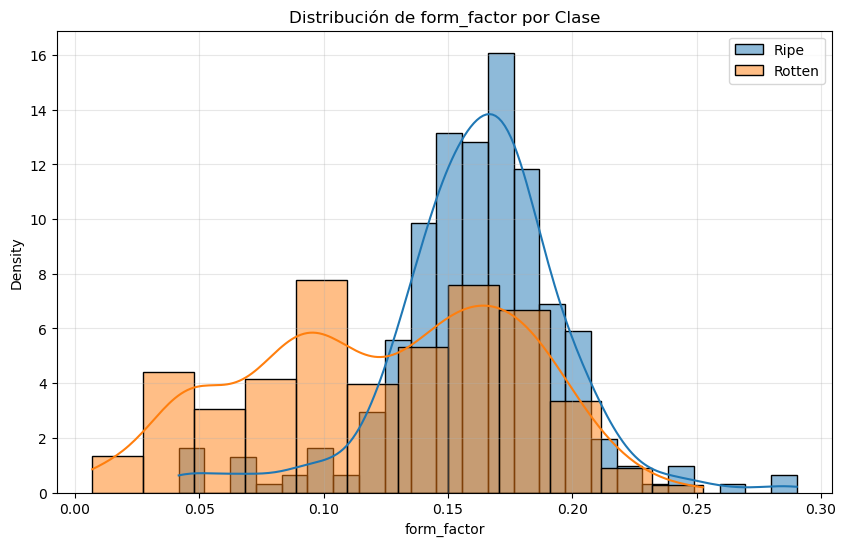

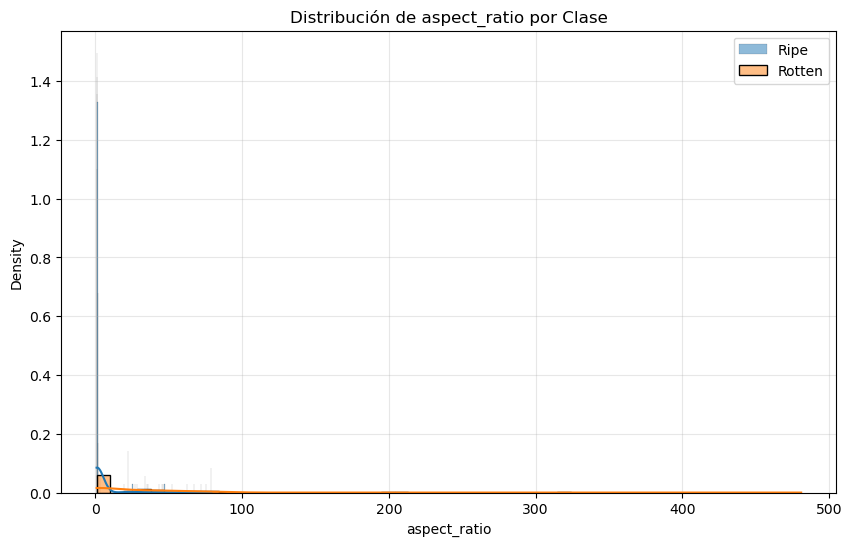

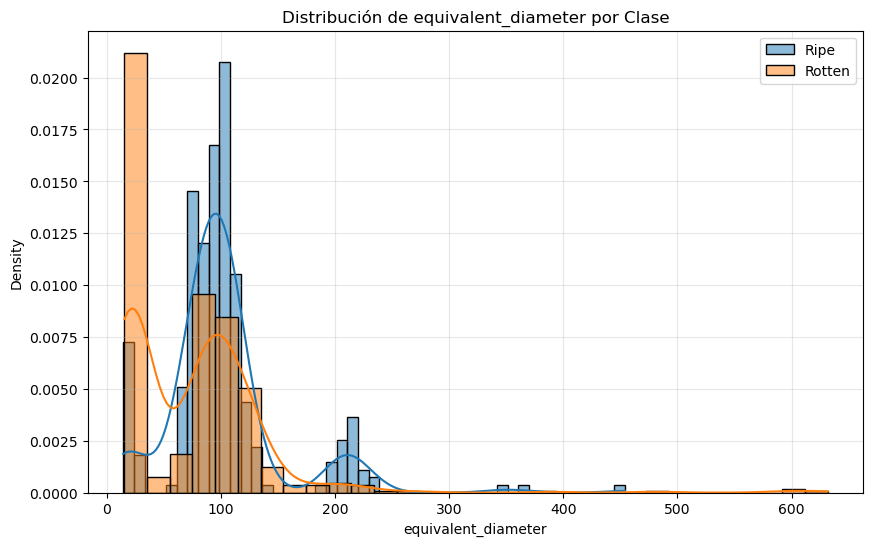

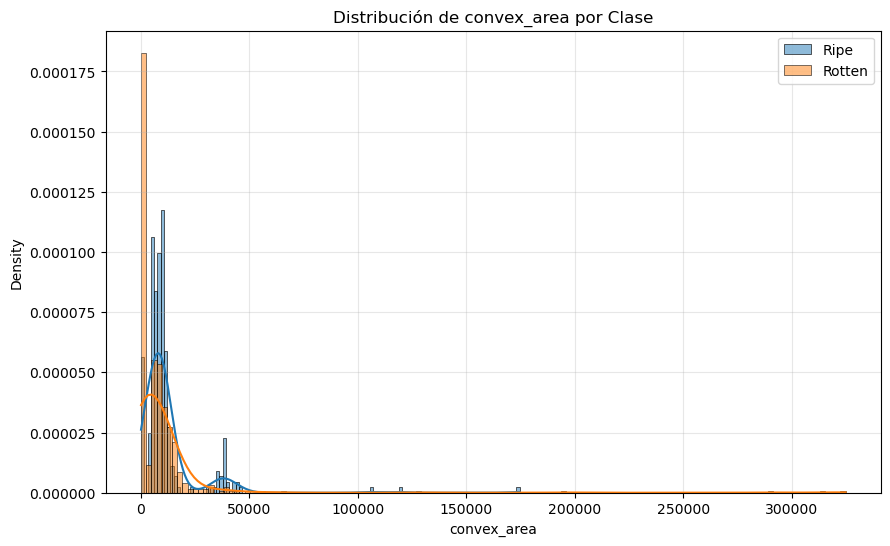


5. Violin plots


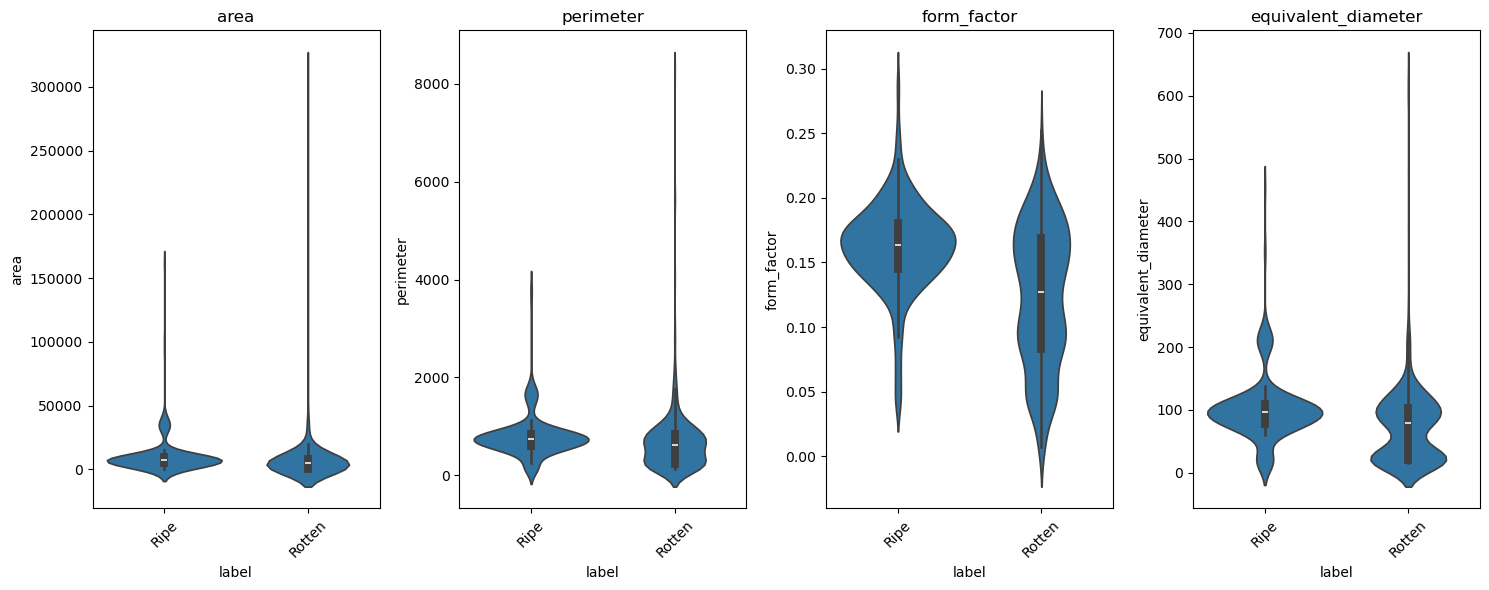


6. Relaciones entre propiedades


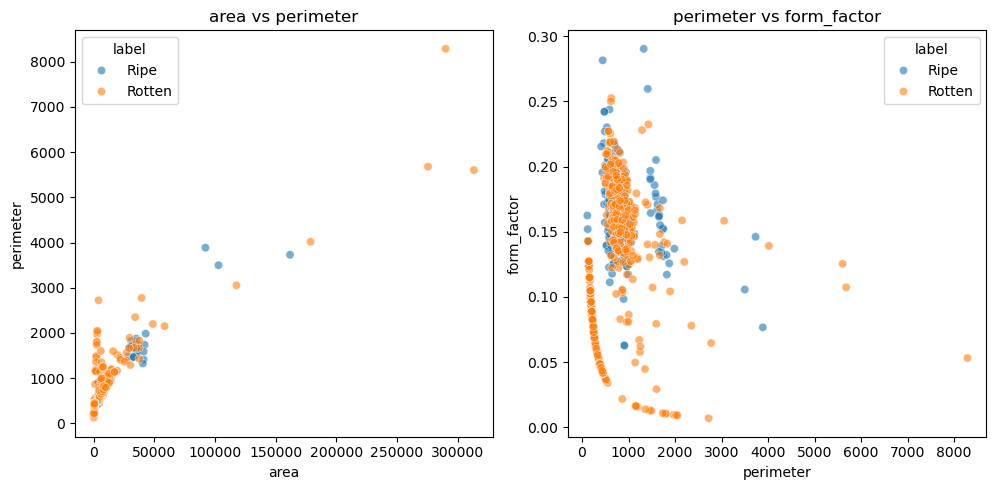

Análisis de Propiedades:


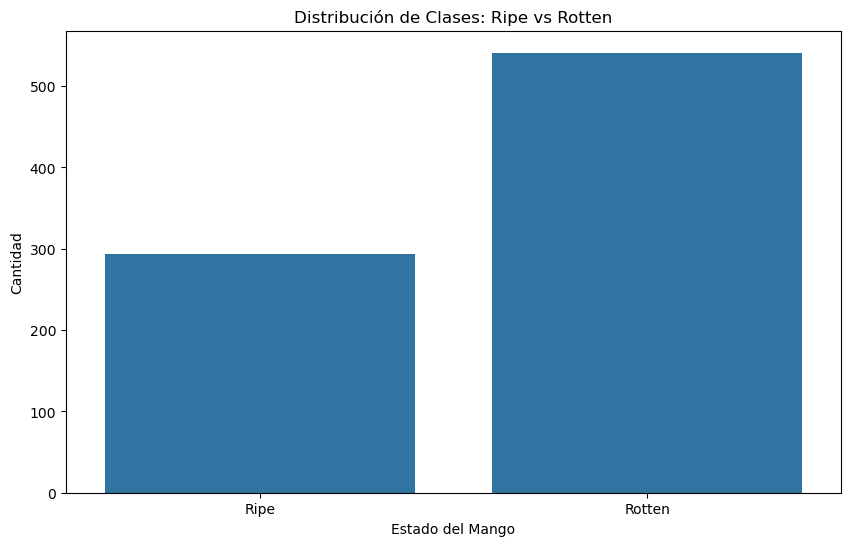

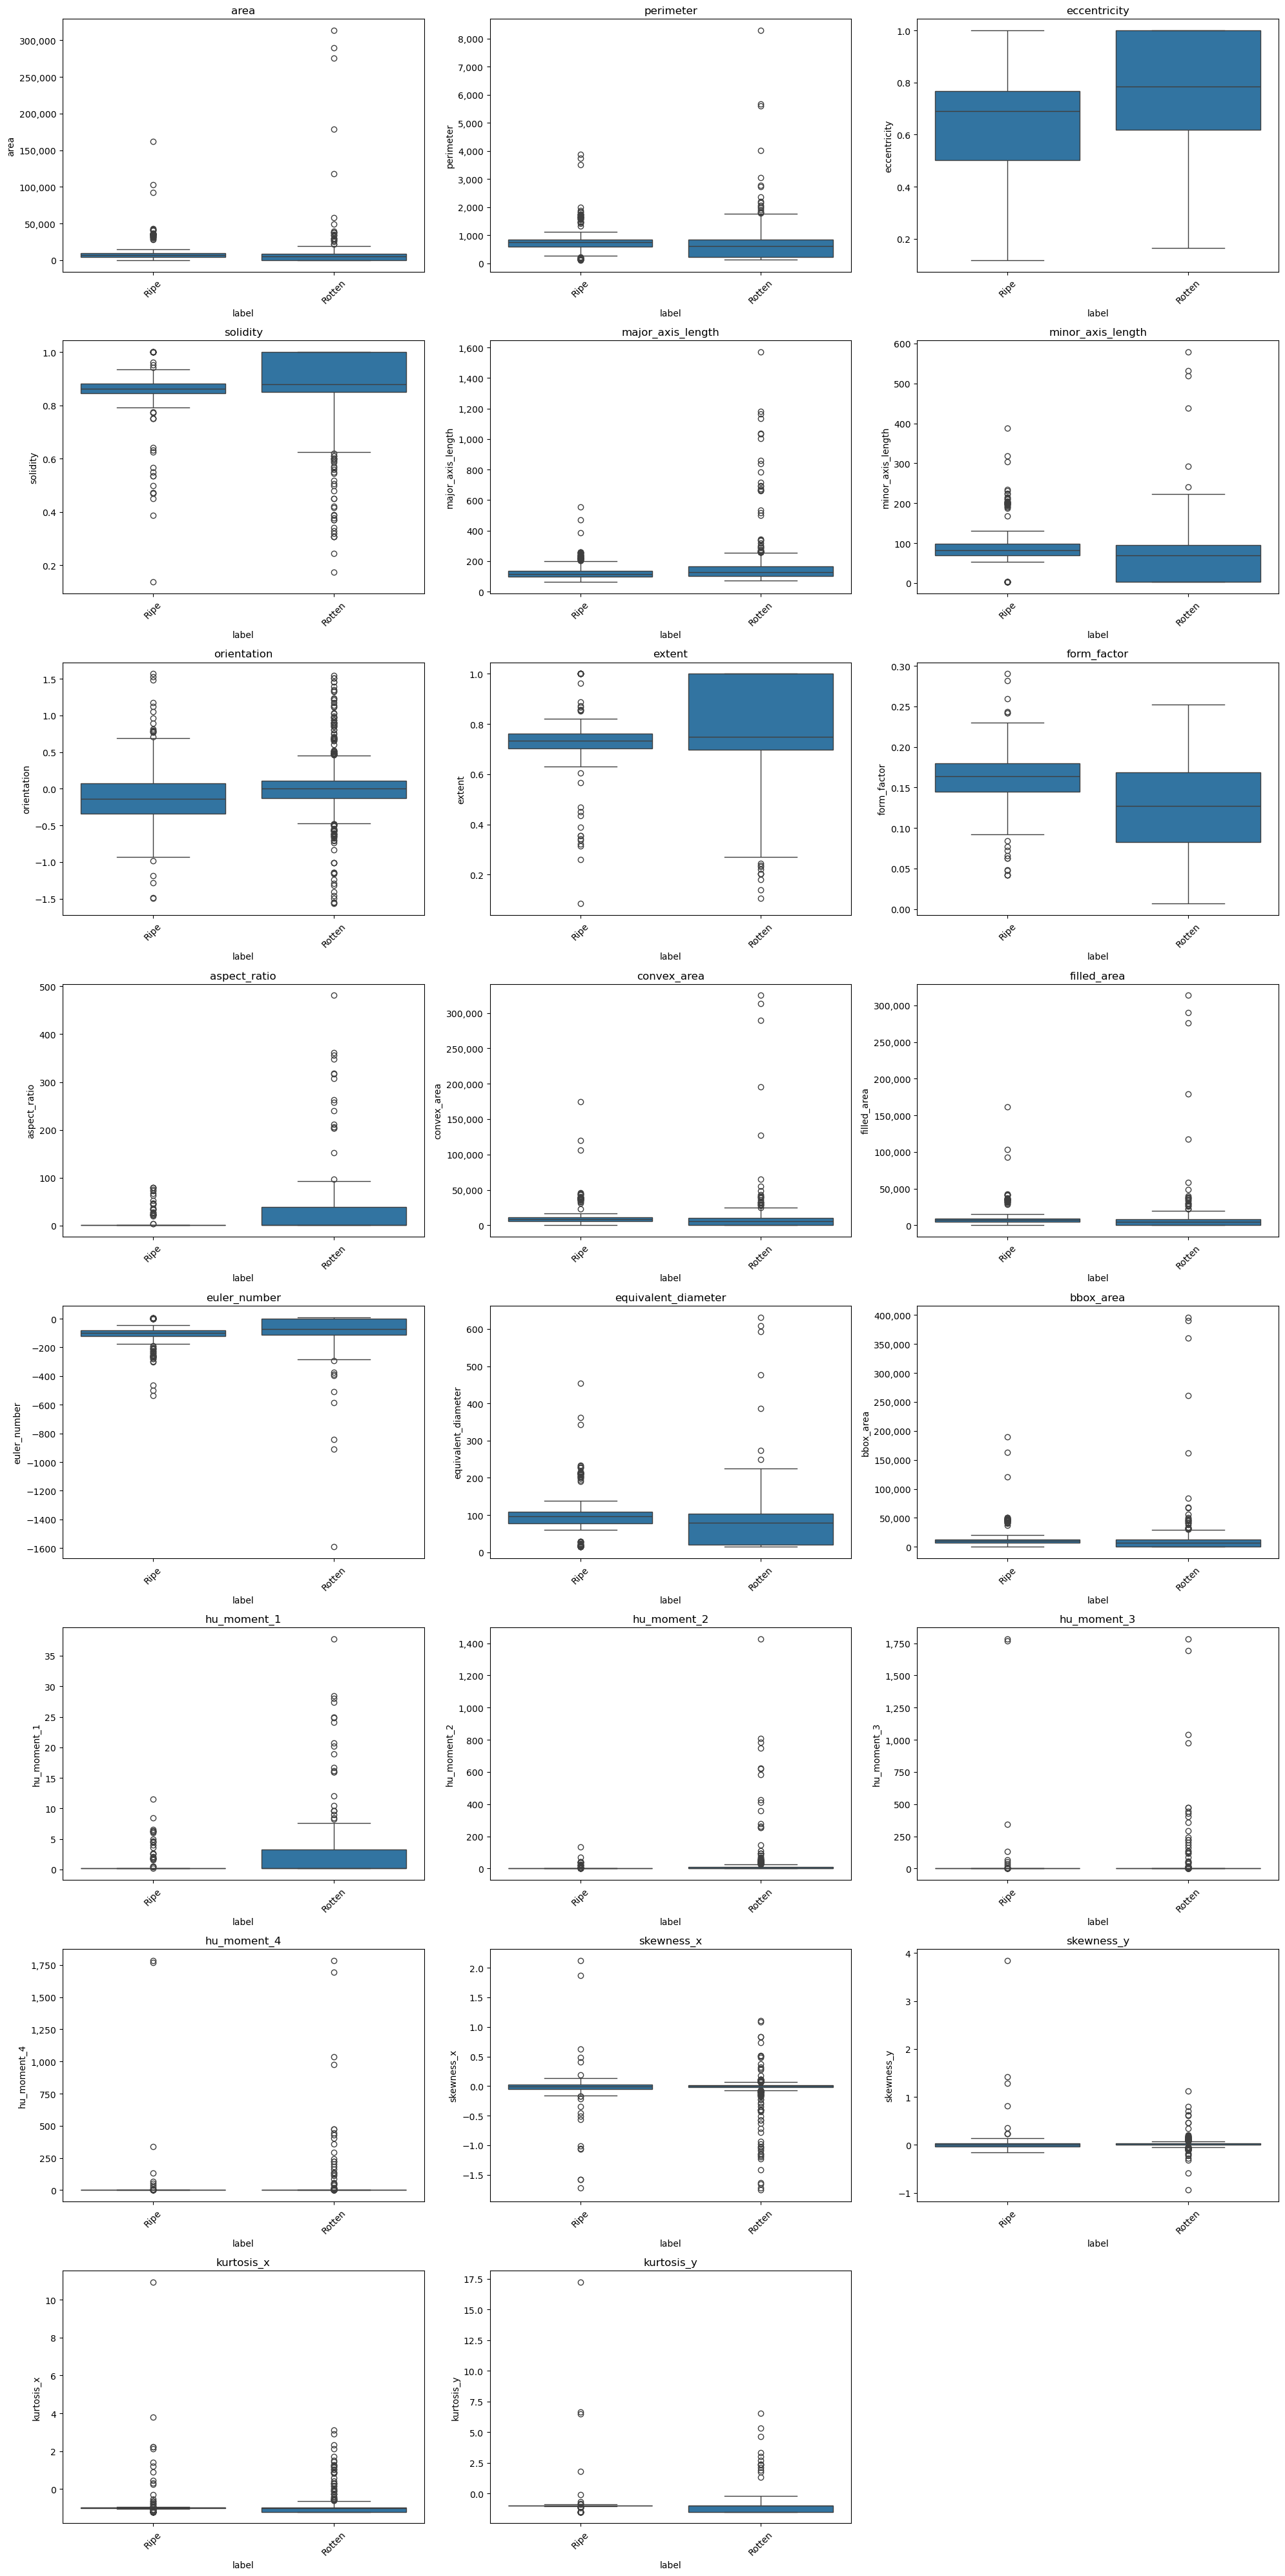

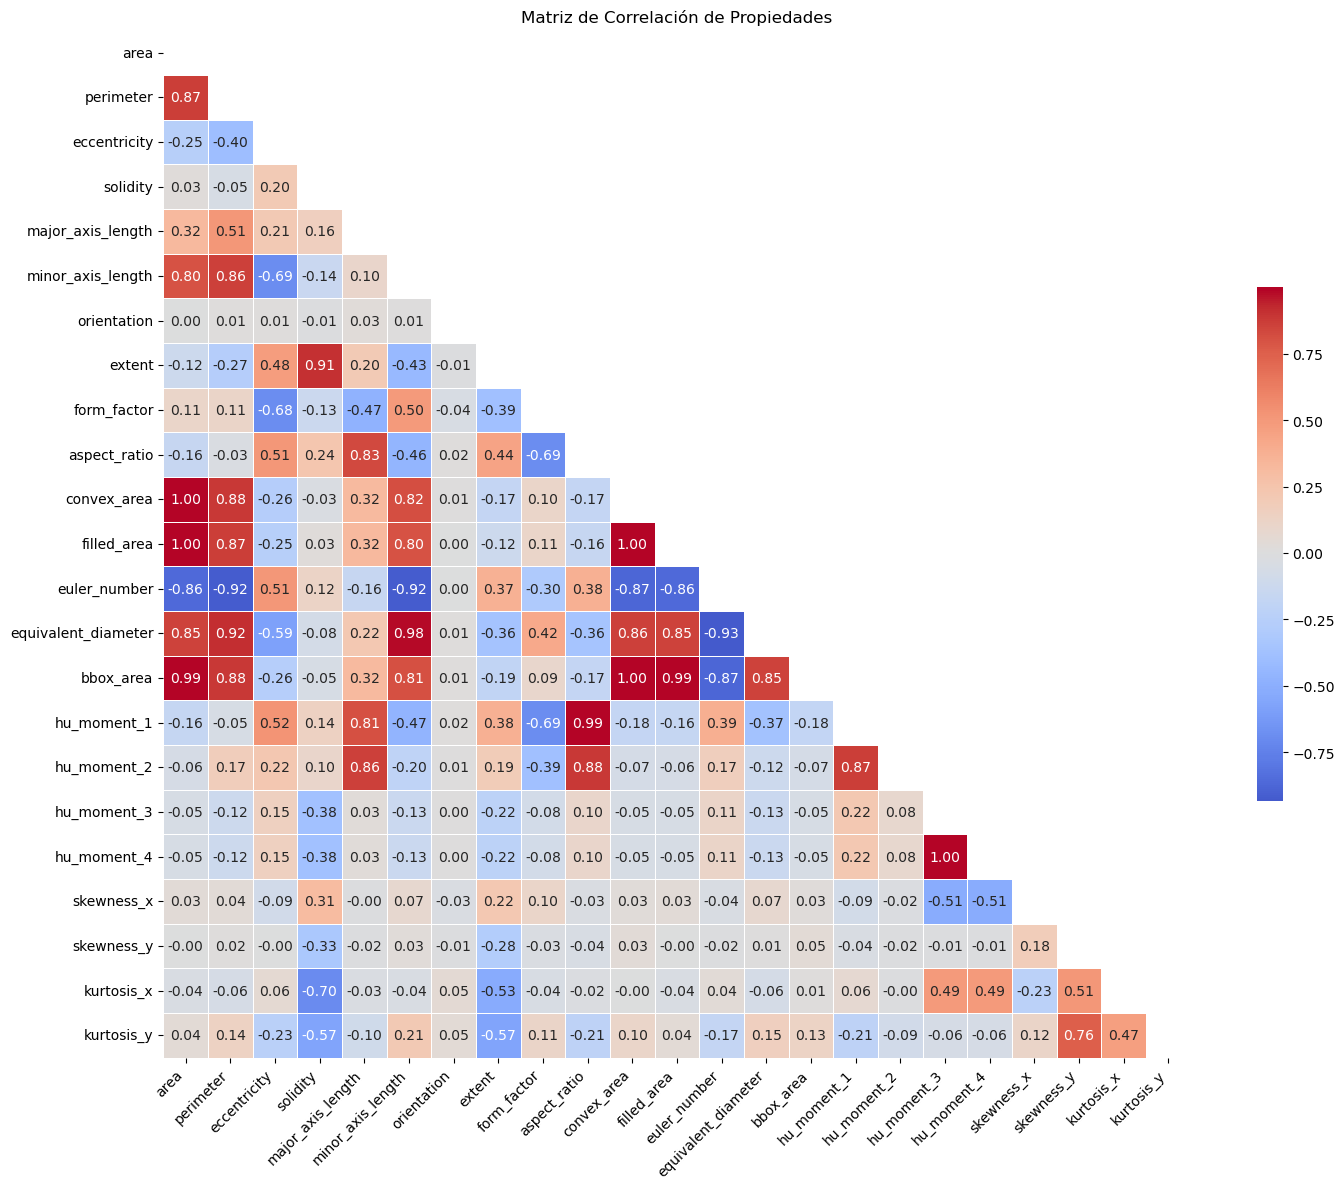

In [47]:
df_properties = analyze_masks_dataset()
visualize_properties(df_properties)
generate_analysis(df_properties)

Realizamos una inspección de las columnas de nuestro dataframe que contiene las propiedades extraídas.

In [54]:
df_properties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 835 entries, 0 to 834
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   area                 835 non-null    float64
 1   perimeter            835 non-null    float64
 2   eccentricity         835 non-null    float64
 3   solidity             835 non-null    float64
 4   major_axis_length    835 non-null    float64
 5   minor_axis_length    835 non-null    float64
 6   orientation          835 non-null    float64
 7   extent               835 non-null    float64
 8   form_factor          835 non-null    float64
 9   aspect_ratio         835 non-null    float64
 10  convex_area          835 non-null    float64
 11  filled_area          835 non-null    float64
 12  euler_number         835 non-null    int64  
 13  equivalent_diameter  835 non-null    float64
 14  bbox_area            835 non-null    float64
 15  hu_moment_1          835 non-null    flo

Hacemos la inspección de las estadisticas para cada variable.

In [57]:
df_properties.describe()

,area,perimeter,eccentricity,solidity,major_axis_length,minor_axis_length,orientation,extent,form_factor,aspect_ratio,...,equivalent_diameter,bbox_area,hu_moment_1,hu_moment_2,hu_moment_3,hu_moment_4,skewness_x,skewness_y,kurtosis_x,kurtosis_y
count,835.000000,835.000000,835.000000,835.000000,835.000000,835.000000,835.000000,835.000000,835.000000,835.000000,...,835.000000,835.000000,835.000000,835.000000,835.000000,8.350000e+02,835.000000,835.000000,835.000000,835.000000
mean,8693.228743,717.858988,0.733858,0.872158,153.539585,69.180250,-0.017099,0.776798,0.137490,20.554737,...,84.001788,12318.440719,1.776244,15.908386,17.660145,1.766052e+01,-0.032769,0.017384,-0.913979,-1.035086
std,21288.467925,580.975567,0.227909,0.125351,127.986842,62.897575,0.444020,0.161148,0.051154,44.058679,...,63.380384,28338.497941,3.577387,83.050763,137.821921,1.378219e+02,0.263669,0.177428,0.657956,0.958241
min,168.000000,114.000000,0.118514,0.138145,64.652920,3.265986,-1.565546,0.085462,0.006920,1.007098,...,14.625466,168.000000,0.159810,0.000001,0.000000,0.000000e+00,-1.759018,-0.942806,-1.200766,-1.500000
25%,603.000000,405.000000,0.574138,0.846548,101.607086,3.265986,-0.260495,0.700378,0.102335,1.221369,...,27.708459,639.000000,0.165809,0.001054,0.000001,4.634862e-09,-0.034013,-0.014341,-1.191257,-1.500000
50%,6022.000000,681.298557,0.739675,0.872239,120.759305,76.700193,0.000000,0.737153,0.149600,1.485964,...,87.563968,8448.000000,0.175803,0.004354,0.000029,3.881755e-07,0.000000,0.000000,-0.995105,-0.997533
75%,8879.000000,853.550865,0.999483,0.974790,150.632740,95.957148,0.096679,0.974790,0.174282,31.110689,...,106.325253,12672.000000,2.446654,5.961428,0.000073,2.009499e-06,0.020158,0.031925,-0.970208,-0.969113
max,313453.000000,8286.676221,0.999998,1.000000,1570.392308,578.299534,1.567872,1.000000,0.290326,480.832481,...,631.744216,396288.000000,37.777921,1427.146605,1784.877537,1.784878e+03,2.122836,3.843219,10.922371,17.226242
